## CLARA multicore scaling

In [1]:
import json
from io import StringIO

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.4
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.autolayout'] = True

### Parameters

In [2]:
params = {
    'date': '2022-07-30',
    'host': 'nid004846',
    'chain': ['MAGFIELDS', 'FTCAL', 'FTHODO', 'FTEB', 'DCCR', 'MLTD', 'DCHAI', 'FTOFHB', 'EC', 'CVTFP', 'CTOF', 'CND', 'BAND', 'HTCC', 'LTCC', 'EBHB', 'DCTB', 'FMT', 'CVTSP', 'FTOFTB', 'EBTB', 'RICH', 'RTPC'],
    'input_file': './clas_006302.evio.00005-00009.hipo',
    'output_file': '/pscratch/sd/t/tylern/clas12/recon/test.hipo',
    'n_events': '2000',
    'jvm_options': ''
}

print(json.dumps(params, indent=4))

{
    "date": "2022-07-30",
    "host": "nid004846",
    "chain": [
        "MAGFIELDS",
        "FTCAL",
        "FTHODO",
        "FTEB",
        "DCCR",
        "MLTD",
        "DCHAI",
        "FTOFHB",
        "EC",
        "CVTFP",
        "CTOF",
        "CND",
        "BAND",
        "HTCC",
        "LTCC",
        "EBHB",
        "DCTB",
        "FMT",
        "CVTSP",
        "FTOFTB",
        "EBTB",
        "RICH",
        "RTPC"
    ],
    "input_file": "./clas_006302.evio.00005-00009.hipo",
    "output_file": "/pscratch/sd/t/tylern/clas12/recon/test.hipo",
    "n_events": "2000",
    "jvm_options": ""
}


### Benchmark

In [3]:
benchmark_data = """\
Cores,READER,MAGFIELDS,FTCAL,FTHODO,FTEB,DCCR,MLTD,DCHAI,FTOFHB,EC,CVTFP,CTOF,CND,BAND,HTCC,LTCC,EBHB,DCTB,FMT,CVTSP,FTOFTB,EBTB,RICH,RTPC,WRITER,TOTAL,Orchestrator
1,0.08,0.02,0.08,0.15,0.04,22.08,16.53,48.77,1.53,0.84,152.49,1.17,0.50,0.03,0.06,0.04,0.50,151.07,0.03,15.60,1.83,1.01,0.39,0.03,3.56,418.43,428.51
2,0.07,0.02,0.10,0.15,0.04,22.22,15.69,49.17,1.56,0.94,155.31,1.08,0.48,0.02,0.04,0.03,0.45,152.90,0.02,15.87,1.73,0.94,0.35,0.02,3.58,422.78,216.47
4,0.06,0.01,0.07,0.14,0.03,22.63,15.17,51.68,1.58,0.91,161.53,0.98,0.46,0.02,0.04,0.03,0.44,157.35,0.02,16.12,1.64,0.85,0.30,0.02,3.57,435.66,111.64
6,0.05,0.01,0.07,0.15,0.03,23.24,15.42,53.88,1.63,0.89,170.73,0.97,0.45,0.02,0.03,0.03,0.41,164.40,0.02,16.83,1.52,0.80,0.28,0.02,3.67,455.53,77.92
8,0.04,0.01,0.07,0.14,0.03,24.44,15.77,56.67,1.62,0.87,178.86,0.95,0.48,0.02,0.03,0.02,0.44,171.24,0.02,17.39,1.51,0.81,0.28,0.02,3.70,475.44,61.08
10,0.04,0.01,0.07,0.15,0.03,25.91,16.66,59.69,1.64,0.92,186.66,0.94,0.43,0.02,0.03,0.02,0.47,179.12,0.02,17.81,1.63,0.80,0.26,0.02,3.69,497.03,51.09
12,0.04,0.02,0.10,0.18,0.03,27.10,18.50,61.73,1.74,0.94,194.65,1.01,0.45,0.02,0.03,0.03,0.48,183.80,0.02,18.66,1.71,0.90,0.26,0.02,3.79,516.22,44.34
14,0.07,0.01,0.06,0.13,0.03,28.32,19.55,66.28,1.71,0.91,202.94,0.97,0.45,0.02,0.03,0.02,0.52,190.33,0.02,19.68,1.69,0.79,0.28,0.02,3.76,538.58,39.87
16,0.06,0.02,0.06,0.16,0.04,29.93,20.79,69.67,1.81,1.02,213.54,1.14,0.46,0.02,0.03,0.03,0.47,202.67,0.02,20.39,1.82,0.86,0.32,0.02,3.82,569.18,37.04
18,0.08,0.03,0.07,0.15,0.03,36.67,26.03,83.39,2.17,1.22,258.59,1.48,0.59,0.02,0.04,0.03,0.53,244.51,0.02,25.02,2.36,1.09,0.35,0.02,4.11,688.59,39.89
20,0.12,0.01,0.12,0.29,0.07,56.25,40.43,125.21,3.09,1.73,396.17,2.38,0.88,0.02,0.03,0.02,0.71,368.83,0.02,36.39,3.03,1.61,0.43,0.02,4.40,1042.27,54.05
22,0.12,0.01,0.13,0.37,0.05,62.20,44.75,138.85,3.52,1.97,445.43,2.80,1.02,0.02,0.05,0.03,0.81,405.14,0.02,41.15,3.44,1.73,0.53,0.02,4.61,1158.76,54.73
24,0.16,0.03,0.16,0.36,0.06,67.36,47.69,150.02,4.03,2.26,484.72,2.77,1.04,0.02,0.03,0.07,0.98,440.39,0.02,44.93,4.29,2.01,0.50,0.02,4.67,1258.61,54.52
26,0.12,0.02,0.18,0.24,0.06,72.15,51.32,155.59,4.12,2.50,508.59,2.78,1.24,0.02,0.07,0.03,0.84,461.39,0.02,46.61,4.20,2.01,0.66,0.02,4.87,1319.65,52.92
28,0.15,0.01,0.19,0.36,0.06,72.13,51.48,157.39,4.41,2.53,520.22,2.94,1.19,0.03,0.03,0.03,0.97,468.74,0.02,47.08,4.60,2.43,0.52,0.02,5.03,1342.58,50.08
30,0.12,0.02,0.19,0.32,0.05,73.84,52.61,159.26,3.89,2.39,532.95,3.13,1.14,0.02,0.06,0.04,1.17,474.85,0.02,48.18,4.46,2.16,0.57,0.02,4.85,1366.30,47.77
32,0.12,0.01,0.17,0.39,0.07,80.32,56.50,175.38,4.23,2.19,584.10,3.68,1.31,0.02,0.06,0.03,1.22,520.13,0.02,52.54,4.64,2.10,0.68,0.02,5.07,1495.01,48.95
34,0.12,0.04,0.24,0.30,0.03,70.01,49.72,154.91,3.97,2.27,504.77,3.03,0.90,0.02,0.04,0.03,1.01,455.26,0.02,45.44,4.05,2.10,0.54,0.02,4.95,1303.79,40.54
36,0.11,0.01,0.17,0.32,0.08,79.76,55.99,168.30,4.75,2.61,549.91,3.25,1.24,0.02,0.10,0.05,1.45,500.27,0.02,50.58,4.48,2.26,0.61,0.02,4.94,1431.31,41.95
38,0.14,0.05,0.22,0.40,0.08,87.86,64.71,187.36,4.57,2.87,616.70,3.55,1.22,0.06,0.06,0.03,1.27,552.74,0.02,55.41,4.70,2.31,0.65,0.02,5.42,1592.42,44.25
40,0.20,0.01,0.23,0.40,0.05,85.96,61.95,185.17,4.89,2.99,615.95,3.19,1.24,0.02,0.07,0.04,1.16,549.92,0.02,54.64,4.61,2.30,0.80,0.02,5.17,1581.00,41.83
42,0.13,0.03,0.19,0.41,0.03,85.01,65.78,185.95,4.83,2.89,628.38,3.87,1.31,0.02,0.06,0.04,1.28,554.06,0.02,54.45,4.27,2.53,0.64,0.02,5.35,1601.55,40.46
44,0.18,0.03,0.11,0.34,0.04,88.51,68.91,191.29,5.16,2.89,643.66,3.59,1.43,0.02,0.05,0.06,1.31,564.83,0.02,55.27,4.48,2.81,0.80,0.02,5.40,1641.23,39.60
46,0.18,0.04,0.21,0.33,0.06,89.47,72.18,191.81,4.69,2.63,645.89,3.95,1.43,0.02,0.06,0.04,1.38,569.93,0.02,57.68,4.80,2.54,0.70,0.02,5.44,1655.51,38.28
48,0.15,0.05,0.13,0.54,0.06,88.80,69.77,187.79,4.97,2.72,633.85,3.53,1.34,0.02,0.10,0.05,1.18,553.98,0.02,55.03,5.10,2.59,0.75,0.02,5.34,1617.89,36.06
50,0.15,0.02,0.15,0.29,0.08,83.40,68.10,182.22,4.51,2.77,621.56,3.79,1.72,0.03,0.04,0.07,1.13,541.16,0.02,52.93,4.95,2.60,0.74,0.02,5.47,1577.92,33.89
52,0.09,0.02,0.20,0.46,0.08,83.78,70.47,186.01,4.86,2.89,632.18,3.47,1.33,0.02,0.03,0.02,1.35,549.36,0.02,53.69,4.91,2.54,0.88,0.02,5.43,1604.11,33.23
54,0.19,0.02,0.18,0.44,0.04,90.24,72.47,193.79,5.26,3.13,671.83,3.99,1.51,0.03,0.05,0.03,1.59,564.72,0.02,56.10,5.21,2.74,0.75,0.02,5.55,1679.92,33.49
56,0.13,0.04,0.23,0.47,0.06,87.63,68.99,195.89,5.47,2.96,680.18,3.95,1.54,0.04,0.08,0.09,1.28,576.85,0.03,56.26,4.98,2.73,0.88,0.02,5.59,1696.37,32.67
58,0.12,0.04,0.20,0.42,0.08,81.47,67.94,177.95,4.96,2.61,636.14,3.64,1.20,0.04,0.08,0.04,1.22,515.43,0.02,51.49,4.96,2.36,0.87,0.02,5.31,1558.61,29.25
60,0.11,0.02,0.14,0.31,0.07,64.44,54.90,140.27,3.99,2.17,478.64,2.96,1.04,0.06,0.05,0.02,1.08,402.81,0.02,40.28,4.03,2.15,0.67,0.02,5.02,1205.26,22.38
62,0.15,0.03,0.21,0.36,0.06,91.04,73.05,193.82,5.21,3.03,710.33,3.93,1.43,0.02,0.12,0.03,1.62,564.32,0.02,54.57,5.21,2.68,0.90,0.02,5.37,1717.51,30.07
64,0.15,0.01,0.18,0.40,0.08,87.19,77.40,194.38,5.18,3.24,707.76,3.96,1.39,0.02,0.07,0.10,1.32,569.30,0.02,56.51,5.12,2.89,0.72,0.02,5.48,1722.87,29.28
66,0.13,0.03,0.15,0.40,0.08,80.77,71.45,180.76,5.54,2.81,662.68,4.04,1.24,0.04,0.08,0.04,1.27,530.55,0.02,53.83,5.36,2.67,0.82,0.02,5.68,1610.45,26.85
68,0.14,0.02,0.21,0.40,0.07,88.55,82.50,198.97,5.58,2.98,737.31,3.88,1.53,0.02,0.08,0.08,1.49,583.68,0.02,57.16,5.43,2.87,0.75,0.02,5.85,1779.59,28.63
70,0.18,0.04,0.24,0.48,0.09,87.67,79.37,194.14,5.43,3.05,729.88,3.71,1.61,0.04,0.06,0.06,1.55,568.59,0.02,55.74,5.76,2.69,0.91,0.02,5.85,1747.18,27.43
72,0.26,0.06,0.26,0.40,0.08,88.30,82.25,196.55,5.30,3.24,749.06,3.97,1.48,0.04,0.07,0.08,1.33,577.40,0.02,56.38,5.86,2.71,0.72,0.02,6.03,1781.88,27.26
74,0.16,0.01,0.22,0.32,0.08,75.39,69.81,170.31,4.87,2.72,648.79,3.79,1.38,0.02,0.05,0.04,1.40,504.96,0.02,49.65,5.22,2.32,0.70,0.02,5.76,1548.00,23.33
76,0.17,0.03,0.22,0.55,0.09,88.30,81.55,194.96,5.48,3.33,770.01,4.54,1.76,0.02,0.05,0.07,1.64,578.74,0.02,55.46,5.20,2.91,0.80,0.02,5.89,1801.84,26.24
78,0.14,0.01,0.29,0.37,0.07,87.55,83.06,193.35,5.46,3.13,768.29,4.35,1.93,0.03,0.10,0.04,1.40,570.17,0.02,55.62,5.78,2.79,0.95,0.02,5.81,1790.73,25.45
80,0.16,0.06,0.22,0.36,0.15,82.62,77.80,177.21,5.16,3.10,740.10,3.72,1.63,0.03,0.11,0.06,1.30,530.78,0.02,52.28,5.16,2.74,0.76,0.02,5.72,1691.26,23.64
82,0.10,0.02,0.19,0.50,0.07,87.63,86.19,194.24,5.66,3.47,790.07,4.14,1.67,0.02,0.11,0.09,1.56,571.44,0.02,55.63,5.82,2.80,0.90,0.02,5.95,1818.33,24.72
84,0.15,0.04,0.21,0.47,0.08,90.58,85.27,195.96,5.71,3.45,813.58,4.43,1.56,0.04,0.10,0.10,1.58,574.60,0.02,55.64,5.51,2.92,0.85,0.02,5.80,1848.67,24.54
86,0.15,0.02,0.24,0.38,0.06,82.65,85.65,184.48,5.21,3.34,776.75,3.91,1.63,0.03,0.09,0.03,1.44,545.70,0.02,53.32,5.40,2.64,0.91,0.02,5.95,1760.01,23.05
88,0.18,0.01,0.25,0.46,0.05,87.31,82.84,189.39,5.64,2.87,823.86,4.49,1.52,0.02,0.09,0.04,1.53,556.22,0.02,54.03,5.47,2.70,0.79,0.03,5.67,1825.52,23.40
90,0.18,0.02,0.31,0.54,0.08,92.69,96.53,200.26,5.79,3.20,849.92,4.63,1.62,0.02,0.12,0.04,1.61,581.93,0.02,55.87,5.69,2.90,0.89,0.02,6.24,1911.12,23.92
92,0.16,0.02,0.17,0.38,0.07,90.91,94.24,194.91,5.33,3.66,857.14,4.57,1.57,0.02,0.06,0.04,1.66,570.71,0.02,54.65,5.76,2.67,0.82,0.02,6.01,1895.59,23.69
94,0.17,0.01,0.20,0.43,0.10,91.66,80.65,196.21,5.66,3.15,896.30,4.92,1.74,0.05,0.09,0.07,1.55,571.98,0.02,54.41,5.64,2.67,0.75,0.02,5.57,1924.02,23.56
96,0.18,0.01,0.22,0.51,0.06,88.37,93.19,191.73,5.11,3.22,853.64,4.59,1.89,0.05,0.10,0.07,1.78,563.21,0.02,54.81,5.34,2.73,0.98,0.02,6.18,1878.03,22.67
98,0.09,0.01,0.21,0.42,0.08,87.58,88.32,188.31,5.71,3.07,893.26,4.73,1.44,0.05,0.14,0.10,1.57,556.29,0.03,54.76,5.65,2.99,0.93,0.02,5.84,1901.59,23.11
100,0.16,0.01,0.21,0.41,0.07,86.55,88.00,191.46,5.66,3.39,907.41,4.19,1.64,0.03,0.07,0.08,1.56,566.49,0.03,54.01,5.71,2.76,0.94,0.02,5.95,1926.82,22.73
102,0.19,0.02,0.19,0.49,0.09,87.90,94.00,193.19,5.56,3.35,930.57,4.30,1.84,0.02,0.08,0.07,1.65,576.73,0.02,55.34,5.57,2.90,0.96,0.02,6.02,1971.06,22.99
104,0.14,0.04,0.31,0.58,0.09,84.19,92.17,187.43,5.65,3.23,893.86,4.70,1.63,0.02,0.07,0.08,1.68,548.92,0.02,52.85,5.75,3.07,1.00,0.02,5.94,1893.44,21.97
106,0.23,0.02,0.27,0.51,0.08,94.64,96.54,203.91,5.87,3.40,989.66,4.71,1.85,0.02,0.06,0.06,1.73,600.20,0.02,56.76,6.20,2.87,0.95,0.02,6.19,2076.79,23.57
108,0.20,0.01,0.23,0.46,0.09,93.48,92.76,204.95,5.95,3.55,1004.64,4.64,1.77,0.03,0.08,0.06,1.58,593.12,0.02,56.40,6.10,3.20,0.97,0.02,6.22,2080.54,23.35
110,0.17,0.02,0.25,0.43,0.13,85.86,86.46,188.87,5.06,3.08,948.49,3.86,1.70,0.03,0.06,0.05,1.60,561.84,0.02,53.28,5.76,2.82,0.90,0.02,5.92,1956.70,21.78
112,0.13,0.01,0.19,0.44,0.08,89.09,94.88,195.30,5.50,3.19,956.62,4.93,1.57,0.03,0.12,0.06,1.77,568.77,0.02,54.37,5.87,3.18,1.04,0.02,6.21,1993.41,21.79
114,0.20,0.04,0.21,0.41,0.06,90.79,94.91,189.34,5.61,3.28,994.05,4.18,1.86,0.02,0.12,0.05,1.59,571.70,0.02,55.49,5.99,2.90,0.92,0.02,6.20,2029.96,22.12
116,0.13,0.02,0.21,0.53,0.07,93.76,99.43,198.28,5.82,3.12,1034.86,4.82,1.61,0.02,0.06,0.10,1.54,583.62,0.03,54.84,5.78,2.81,0.92,0.02,6.25,2098.65,22.55
118,0.21,0.04,0.25,0.70,0.05,95.79,100.82,205.19,5.75,3.75,1069.85,4.44,2.09,0.03,0.06,0.06,1.62,598.32,0.03,56.58,5.76,3.18,1.07,0.02,6.12,2161.78,22.83
120,0.19,0.02,0.17,0.38,0.12,88.93,91.15,198.39,5.96,3.29,1023.77,4.79,1.62,0.02,0.10,0.07,1.66,575.37,0.02,53.95,6.04,3.04,0.78,0.03,6.05,2065.93,21.66
122,0.13,0.04,0.30,0.66,0.07,92.45,94.61,200.15,5.92,3.31,1040.04,4.82,1.74,0.04,0.11,0.06,1.63,577.06,0.02,54.76,5.90,3.16,1.02,0.02,6.10,2094.12,21.65
124,0.22,0.01,0.32,0.46,0.14,88.76,92.95,192.26,6.03,3.22,1026.44,5.03,1.84,0.04,0.12,0.07,1.61,564.45,0.02,52.37,5.87,2.89,0.86,0.02,6.14,2052.15,21.05
126,0.17,0.02,0.25,0.66,0.07,92.25,102.48,201.40,5.69,3.62,1084.21,4.59,1.81,0.05,0.07,0.09,1.79,592.23,0.03,55.95,6.16,2.81,0.94,0.02,6.23,2163.60,21.85
128,0.26,0.05,0.27,0.62,0.11,101.14,108.22,210.05,6.17,3.31,1112.26,3.90,1.65,0.05,0.12,0.12,1.69,597.79,0.03,56.93,5.75,3.10,0.97,0.02,6.22,2220.80,21.93
130,0.14,0.01,0.26,0.54,0.06,89.83,87.31,196.58,5.89,3.59,1068.68,4.67,1.65,0.03,0.11,0.06,1.65,568.52,0.02,54.14,5.85,3.15,1.11,0.02,5.96,2099.83,20.69
132,0.18,0.01,0.24,0.48,0.13,94.09,104.03,209.51,5.78,3.51,1137.31,5.02,1.93,0.05,0.12,0.11,1.70,593.48,0.02,56.34,5.64,2.94,1.09,0.03,6.48,2230.23,21.68
134,0.15,0.04,0.21,0.53,0.11,99.63,111.59,208.41,6.14,3.68,1163.12,4.71,1.93,0.04,0.09,0.09,1.92,600.97,0.02,56.48,6.44,3.23,1.07,0.04,6.67,2277.31,21.88
136,0.15,0.02,0.33,0.49,0.08,92.64,104.37,205.48,6.36,3.71,1115.38,5.42,2.04,0.03,0.08,0.04,1.85,587.89,0.02,56.71,6.69,3.23,1.02,0.02,6.72,2200.76,21.01
138,0.22,0.04,0.26,0.65,0.09,96.06,101.44,207.33,6.00,3.85,1175.88,4.70,1.87,0.02,0.13,0.11,1.60,607.56,0.02,56.62,6.27,3.28,1.02,0.02,6.19,2281.28,21.46
140,0.21,0.03,0.25,0.52,0.08,102.53,104.33,214.33,6.58,3.84,1227.22,5.01,2.00,0.05,0.11,0.11,1.88,615.58,0.02,57.66,6.17,3.17,1.05,0.02,6.46,2359.23,21.73
142,0.20,0.02,0.29,0.54,0.12,99.90,105.71,214.56,6.29,3.90,1224.93,5.46,1.98,0.03,0.12,0.06,1.59,609.95,0.02,57.38,6.76,3.35,1.00,0.02,6.50,2350.69,21.57
144,0.14,0.01,0.27,0.59,0.11,97.51,110.50,208.22,6.54,3.74,1221.38,5.39,2.02,0.02,0.10,0.14,1.63,593.49,0.02,56.50,6.50,2.95,1.10,0.02,6.56,2325.51,21.19
146,0.17,0.04,0.19,0.45,0.08,97.21,105.78,210.03,5.97,3.88,1231.19,5.20,1.90,0.03,0.12,0.11,1.84,612.75,0.02,57.68,6.81,3.10,1.32,0.03,6.69,2352.60,21.13
148,0.24,0.02,0.29,0.52,0.08,104.81,110.96,214.52,6.36,4.20,1243.71,5.61,2.53,0.04,0.15,0.10,1.87,607.24,0.03,57.95,6.47,3.78,1.09,0.02,6.12,2378.72,21.10
150,0.18,0.01,0.28,0.60,0.16,100.72,101.07,212.27,6.17,4.06,1251.02,5.25,2.10,0.03,0.06,0.09,1.85,609.63,0.03,56.43,6.62,3.02,1.10,0.02,6.42,2369.19,20.80
152,0.19,0.02,0.34,0.63,0.12,98.51,105.21,206.96,6.21,3.73,1224.15,5.01,2.10,0.03,0.08,0.07,1.79,589.32,0.02,54.99,6.58,3.33,1.04,0.02,6.77,2317.22,20.38
154,0.23,0.01,0.27,0.63,0.13,98.96,102.45,213.94,7.21,4.41,1257.42,5.23,2.32,0.03,0.16,0.08,1.75,603.00,0.03,57.28,6.81,3.37,1.26,0.02,6.45,2373.43,20.59
156,0.13,0.02,0.39,0.85,0.12,104.92,99.51,218.32,7.00,4.11,1280.99,6.04,2.29,0.05,0.11,0.16,2.02,619.11,0.03,58.06,6.98,2.88,0.98,0.02,6.38,2421.47,20.66
158,0.27,0.02,0.39,0.66,0.14,103.16,100.90,212.73,7.41,4.91,1258.54,5.80,2.63,0.03,0.12,0.10,2.10,607.84,0.02,56.51,6.84,3.33,1.27,0.02,6.44,2382.19,20.22
160,0.18,0.04,0.26,0.64,0.14,106.46,115.99,216.56,6.94,4.33,1323.29,5.93,2.08,0.03,0.12,0.10,2.00,623.69,0.03,58.35,6.12,3.43,1.29,0.03,6.66,2484.69,20.85
162,0.18,0.03,0.26,0.57,0.11,101.67,103.90,218.26,7.01,4.51,1296.63,5.43,2.28,0.03,0.07,0.10,1.87,609.85,0.03,57.56,6.95,3.03,1.07,0.02,6.75,2428.18,20.35
164,0.30,0.02,0.37,0.65,0.20,103.81,99.20,217.96,8.21,4.98,1306.42,5.73,2.22,0.07,0.15,0.07,2.03,605.25,0.04,57.80,7.50,3.37,1.32,0.03,6.34,2434.07,20.13
166,0.22,0.01,0.28,0.58,0.17,97.34,103.33,215.07,8.21,4.74,1291.83,6.27,2.70,0.03,0.09,0.07,2.20,604.14,0.03,56.09,7.59,3.54,1.34,0.02,6.67,2412.57,19.80
168,0.12,0.02,0.37,0.56,0.13,96.77,98.04,213.35,7.99,4.73,1312.44,6.13,2.47,0.03,0.15,0.13,2.14,602.14,0.03,58.11,6.97,3.21,1.19,0.02,6.76,2423.99,19.71
170,0.21,0.03,0.37,0.67,0.16,106.09,111.74,218.17,7.40,4.48,1367.40,5.62,2.48,0.04,0.12,0.07,2.37,629.65,0.03,58.53,7.21,3.06,1.13,0.03,6.91,2533.94,20.30
172,0.23,0.01,0.33,0.76,0.17,94.75,99.56,217.56,9.54,4.97,1291.18,6.51,2.68,0.06,0.16,0.11,2.13,591.42,0.03,56.70,7.59,3.25,1.18,0.02,6.61,2397.49,19.32
174,0.15,0.03,0.31,0.84,0.15,106.04,107.16,214.33,8.11,5.20,1367.24,6.30,2.54,0.06,0.15,0.11,2.18,618.83,0.03,58.08,7.35,3.65,1.05,0.02,6.84,2516.75,19.94
176,0.21,0.01,0.40,0.72,0.12,94.73,107.70,216.33,10.74,5.57,1365.52,6.40,2.81,0.06,0.16,0.11,2.70,617.53,0.03,58.79,7.52,3.61,1.35,0.02,7.00,2510.13,19.64
178,0.25,0.01,0.41,0.70,0.13,98.48,108.94,213.97,8.28,5.35,1327.58,6.76,2.93,0.05,0.11,0.13,2.72,601.05,0.03,59.20,8.40,3.30,1.27,0.03,7.03,2457.10,19.32
180,0.25,0.02,0.36,0.72,0.23,103.29,106.83,219.28,10.23,5.22,1333.78,7.39,3.21,0.05,0.14,0.12,2.57,623.65,0.03,60.05,8.92,3.90,1.26,0.02,6.94,2498.46,19.42
182,0.23,0.04,0.39,0.70,0.17,114.18,111.11,220.05,7.75,5.34,1391.98,6.65,2.64,0.06,0.20,0.12,2.55,632.71,0.03,60.04,8.05,3.52,1.23,0.04,6.77,2576.55,19.71
184,0.20,0.03,0.36,0.72,0.19,115.86,109.98,228.07,8.35,5.11,1422.72,7.51,3.21,0.06,0.13,0.12,2.78,643.89,0.03,61.09,8.34,3.86,1.29,0.04,6.91,2630.85,19.92
186,0.20,0.01,0.34,0.75,0.15,114.41,111.64,224.50,8.80,5.49,1404.25,7.65,3.24,0.03,0.17,0.13,2.98,636.91,0.03,59.55,8.25,3.48,1.29,0.02,7.01,2601.30,19.71
188,0.34,0.01,0.43,0.81,0.19,111.01,114.99,226.11,10.52,6.26,1395.25,8.95,3.67,0.03,0.20,0.12,2.80,635.65,0.03,62.60,9.05,4.28,1.59,0.06,6.96,2601.90,19.46
190,0.17,0.01,0.44,0.91,0.19,115.95,111.58,227.65,9.02,5.69,1431.52,8.09,3.51,0.04,0.14,0.18,3.08,657.85,0.03,62.81,8.56,3.81,1.63,0.02,7.06,2659.92,19.70
192,0.20,0.02,0.38,0.82,0.15,102.17,95.59,219.62,11.84,6.50,1379.68,8.06,3.48,0.05,0.17,0.10,2.83,611.64,0.03,58.08,8.94,3.83,1.48,0.03,6.70,2522.40,18.74
194,0.25,0.01,0.47,1.04,0.20,117.73,118.49,226.54,8.98,6.19,1435.80,8.22,3.71,0.05,0.17,0.14,2.78,648.83,0.03,61.27,9.07,3.65,1.55,0.02,7.06,2662.25,19.50
196,0.29,0.02,0.41,0.93,0.25,117.78,117.88,234.11,10.23,6.33,1446.72,8.33,3.96,0.07,0.21,0.10,2.92,655.84,0.03,63.69,8.69,3.82,1.40,0.04,7.24,2691.28,19.45
198,0.28,0.03,0.29,1.01,0.17,106.59,99.30,226.22,11.95,6.67,1418.09,9.26,3.72,0.05,0.20,0.14,3.14,643.23,0.03,62.46,9.82,4.32,1.53,0.03,6.90,2615.45,18.81
200,0.22,0.02,0.52,0.93,0.38,123.85,141.27,241.58,10.96,7.34,1553.60,8.51,4.20,0.09,0.21,0.12,3.31,711.02,0.03,66.70,10.29,4.46,1.62,0.02,7.90,2899.14,20.40
202,0.29,0.01,0.50,1.15,0.20,114.65,103.87,237.81,12.87,8.04,1457.18,9.49,4.33,0.07,0.24,0.12,3.78,657.40,0.03,64.12,10.57,4.16,1.81,0.02,6.94,2699.65,19.22
204,0.22,0.03,0.48,1.06,0.23,121.65,125.49,226.33,10.92,7.08,1494.50,8.93,4.15,0.09,0.23,0.11,3.54,664.27,0.03,63.89,10.46,3.88,1.81,0.04,7.41,2756.82,19.39
206,0.22,0.02,0.53,1.08,0.16,110.78,105.61,234.94,13.09,8.72,1497.75,10.28,4.55,0.09,0.19,0.14,3.51,665.17,0.04,64.03,9.87,4.01,1.67,0.02,7.20,2743.70,19.20
208,0.37,0.01,0.47,1.36,0.19,110.75,105.95,234.33,13.54,8.75,1452.19,10.56,4.50,0.10,0.26,0.20,3.82,657.55,0.03,66.07,10.91,4.42,1.68,0.04,7.18,2695.20,18.67
210,0.36,0.02,0.59,1.60,0.23,126.44,135.56,245.71,14.27,9.22,1529.75,10.31,5.75,0.06,0.23,0.18,4.13,712.64,0.03,69.70,11.87,5.26,1.88,0.03,7.43,2893.24,19.80
212,0.26,0.01,0.55,1.31,0.28,136.07,126.32,246.30,13.14,9.25,1564.50,11.33,5.77,0.04,0.19,0.16,4.63,707.63,0.03,70.81,11.46,4.81,2.05,0.06,7.79,2924.77,19.87
214,0.37,0.01,0.67,1.69,0.34,129.66,132.06,242.88,14.44,9.96,1589.60,11.85,6.08,0.04,0.20,0.20,4.74,719.98,0.03,72.78,11.72,4.77,1.98,0.02,7.68,2963.79,19.95
216,0.32,0.01,0.68,1.50,0.31,123.13,112.30,247.25,18.76,11.37,1496.58,13.98,6.72,0.11,0.28,0.17,5.34,682.57,0.03,73.40,15.95,5.97,2.73,0.03,7.05,2826.56,19.06
218,0.41,0.03,0.85,1.72,0.38,135.56,151.78,245.49,13.75,10.11,1605.41,13.23,7.06,0.10,0.30,0.18,5.04,728.22,0.03,72.30,12.52,5.98,2.05,0.03,8.06,3020.59,20.20
220,0.28,0.01,0.76,1.92,0.35,144.49,133.48,258.11,17.20,11.50,1646.78,12.61,7.27,0.05,0.24,0.23,5.41,738.96,0.03,74.63,14.80,5.50,2.53,0.02,7.98,3085.13,20.26
222,0.38,0.01,0.75,1.86,0.56,143.64,140.26,263.33,17.30,11.61,1661.28,14.55,7.63,0.15,0.27,0.27,6.33,749.17,0.03,74.71,14.40,5.77,2.55,0.03,8.07,3124.89,20.34
224,0.35,0.02,0.78,1.94,0.35,140.39,135.82,241.83,18.19,12.87,1578.99,15.39,8.48,0.06,0.24,0.28,6.07,724.90,0.03,74.14,14.03,6.19,2.88,0.03,7.56,2991.81,19.54
226,0.35,0.02,0.76,1.91,0.37,141.53,142.55,258.00,17.36,13.43,1622.66,15.05,8.84,0.10,0.26,0.24,6.85,734.53,0.03,77.95,15.45,6.47,2.59,0.04,8.20,3075.54,19.96
228,0.34,0.04,0.89,2.52,0.40,135.47,157.51,252.54,21.45,15.23,1677.61,14.90,9.52,0.09,0.29,0.35,7.00,755.57,0.03,80.62,16.23,6.73,3.07,0.03,8.38,3166.79,20.23
230,0.44,0.01,1.02,2.51,0.50,141.46,180.44,258.12,20.97,15.95,1711.21,17.17,9.32,0.07,0.43,0.24,7.41,795.60,0.03,79.12,16.61,6.21,3.11,0.04,8.86,3276.85,20.69
232,0.48,0.01,1.03,2.53,0.53,148.60,146.14,268.08,24.06,16.86,1650.10,18.03,10.86,0.06,0.29,0.33,8.57,783.55,0.03,85.99,19.05,7.70,3.74,0.03,8.30,3204.92,20.22
234,0.37,0.04,1.16,2.63,0.54,150.62,148.74,264.09,20.92,16.24,1679.17,16.77,9.93,0.10,0.37,0.33,8.40,758.42,0.03,79.82,16.55,6.89,3.40,0.04,8.33,3193.89,20.06
236,0.47,0.01,1.14,2.78,0.66,158.35,179.20,274.39,23.53,17.34,1729.16,19.29,12.37,0.11,0.36,0.32,9.28,805.08,0.03,87.51,18.81,7.63,3.34,0.03,8.81,3359.99,20.77
238,0.61,0.04,1.28,2.63,0.64,140.38,138.79,264.75,27.93,19.44,1676.21,20.34,12.24,0.13,0.50,0.40,10.23,764.09,0.03,84.45,21.13,7.65,4.25,0.03,8.14,3206.31,19.89
240,0.52,0.01,1.17,2.88,0.75,160.52,168.78,282.17,25.23,17.76,1754.74,19.68,12.76,0.13,0.41,0.38,10.67,812.07,0.03,87.26,21.16,8.18,3.79,0.04,8.50,3399.61,20.85
242,0.52,0.01,1.22,2.67,0.66,159.47,144.94,272.29,30.06,19.95,1619.94,20.04,12.54,0.12,0.55,0.34,10.18,792.46,0.03,89.33,23.36,7.88,3.84,0.08,7.93,3220.40,19.71
244,0.45,0.01,1.46,3.63,0.71,167.74,207.11,280.95,26.17,18.96,1879.18,19.67,13.61,0.11,0.50,0.57,11.41,869.43,0.03,94.78,21.75,8.29,3.97,0.05,10.06,3640.58,21.87
246,0.59,0.01,1.45,4.25,0.77,165.09,156.90,283.68,27.73,21.35,1772.38,22.10,12.60,0.15,0.56,0.37,11.77,820.98,0.03,90.14,21.68,8.86,4.25,0.04,8.57,3436.30,20.71
248,0.63,0.01,1.73,4.29,1.04,167.28,207.87,282.82,26.58,21.64,1900.34,21.23,14.27,0.08,0.55,0.37,11.80,885.84,0.03,95.01,22.12,8.70,3.97,0.05,9.75,3688.01,21.92
250,0.70,0.01,1.79,4.56,0.87,169.18,191.44,278.96,28.38,21.77,1817.15,22.76,13.91,0.14,0.51,0.36,12.83,850.65,0.03,93.74,23.48,9.03,4.78,0.05,9.14,3556.22,21.15
252,0.59,0.01,2.00,4.64,1.01,161.77,193.94,278.06,30.69,23.93,1853.80,22.85,15.80,0.12,0.53,0.35,13.63,857.26,0.03,92.77,24.42,9.49,4.78,0.03,8.90,3601.39,21.24
254,0.67,0.01,2.04,4.96,1.10,158.85,201.47,272.75,34.54,23.81,1803.59,24.47,15.79,0.21,0.53,0.39,12.70,853.59,0.03,95.21,25.98,9.09,5.19,0.04,9.15,3556.15,21.03
256,0.85,0.02,2.24,5.22,1.20,169.64,207.71,287.90,30.80,24.29,1871.54,23.67,16.40,0.16,0.60,0.56,13.32,878.53,0.03,98.12,26.63,9.04,5.36,0.03,9.22,3683.08,21.51"""

df = pd.read_csv(StringIO(benchmark_data))

In [4]:
df['EvRate'] = 1000 / df['Orchestrator']

pd.options.display.max_columns = None
pd.options.display.precision = 2
df

,Cores,READER,MAGFIELDS,FTCAL,FTHODO,FTEB,DCCR,MLTD,DCHAI,FTOFHB,EC,CVTFP,CTOF,CND,BAND,HTCC,LTCC,EBHB,DCTB,FMT,CVTSP,FTOFTB,EBTB,RICH,RTPC,WRITER,TOTAL,Orchestrator,EvRate
0,1,0.08,0.02,0.08,0.15,0.04,22.08,16.53,48.77,1.53,0.84,152.49,1.17,0.50,0.03,0.06,0.04,0.50,151.07,0.03,15.60,1.83,1.01,0.39,0.03,3.56,418.43,428.51,2.33
1,2,0.07,0.02,0.10,0.15,0.04,22.22,15.69,49.17,1.56,0.94,155.31,1.08,0.48,0.02,0.04,0.03,0.45,152.90,0.02,15.87,1.73,0.94,0.35,0.02,3.58,422.78,216.47,4.62
2,4,0.06,0.01,0.07,0.14,0.03,22.63,15.17,51.68,1.58,0.91,161.53,0.98,0.46,0.02,0.04,0.03,0.44,157.35,0.02,16.12,1.64,0.85,0.30,0.02,3.57,435.66,111.64,8.96
3,6,0.05,0.01,0.07,0.15,0.03,23.24,15.42,53.88,1.63,0.89,170.73,0.97,0.45,0.02,0.03,0.03,0.41,164.40,0.02,16.83,1.52,0.80,0.28,0.02,3.67,455.53,77.92,12.83
4,8,0.04,0.01,0.07,0.14,0.03,24.44,15.77,56.67,1.62,0.87,178.86,0.95,0.48,0.02,0.03,0.02,0.44,171.24,0.02,17.39,1.51,0.81,0.28,0.02,3.70,475.44,61.08,16.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,248,0.63,0.01,1.73,4.29,1.04,167.28,207.87,282.82,26.58,21.64,1900.34,21.23,14.27,0.08,0.55,0.37,11.80,885.84,0.03,95.01,22.12,8.70,3.97,0.05,9.75,3688.01,21.92,45.62
125,250,0.70,0.01,1.79,4.56,0.87,169.18,191.44,278.96,28.38,21.77,1817.15,22.76,13.91,0.14,0.51,0.36,12.83,850.65,0.03,93.74,23.48,9.03,4.78,0.05,9.14,3556.22,21.15,47.28
126,252,0.59,0.01,2.00,4.64,1.01,161.77,193.94,278.06,30.69,23.93,1853.80,22.85,15.80,0.12,0.53,0.35,13.63,857.26,0.03,92.77,24.42,9.49,4.78,0.03,8.90,3601.39,21.24,47.08
127,254,0.67,0.01,2.04,4.96,1.10,158.85,201.47,272.75,34.54,23.81,1803.59,24.47,15.79,0.21,0.53,0.39,12.70,853.59,0.03,95.21,25.98,9.09,5.19,0.04,9.15,3556.15,21.03,47.55


### Plots

In [5]:
title = 'Scaling test - CLARA 4.3-SNAPSHOT - nid004846 - 2000 events'
xlim = (0, 258)
xticks = range(0, 258, 4)

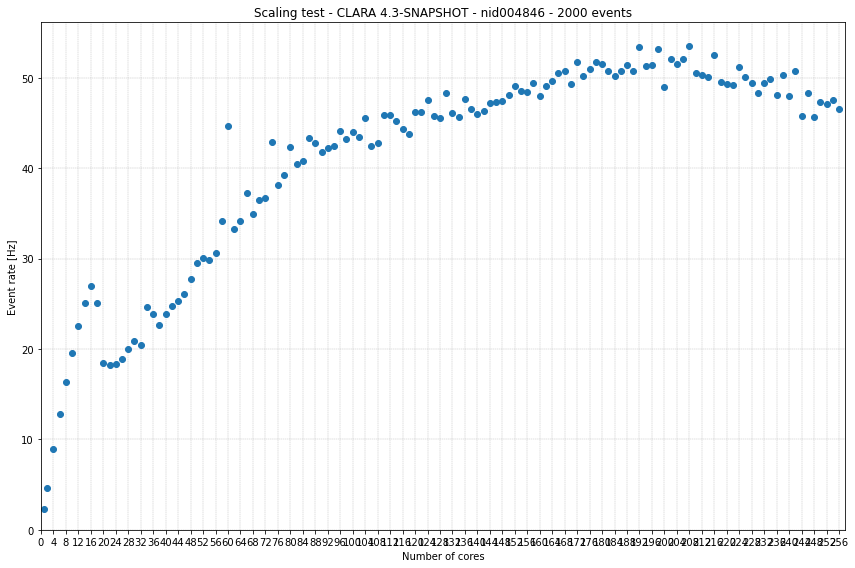

In [6]:
ax = df.plot(x='Cores', y='EvRate', style='o', legend=False, xlim=xlim, xticks=xticks)
ax.set_title(title)
ax.set_ylim(bottom=0)
ax.set_xlabel('Number of cores')
ax.set_ylabel('Event rate [Hz]');

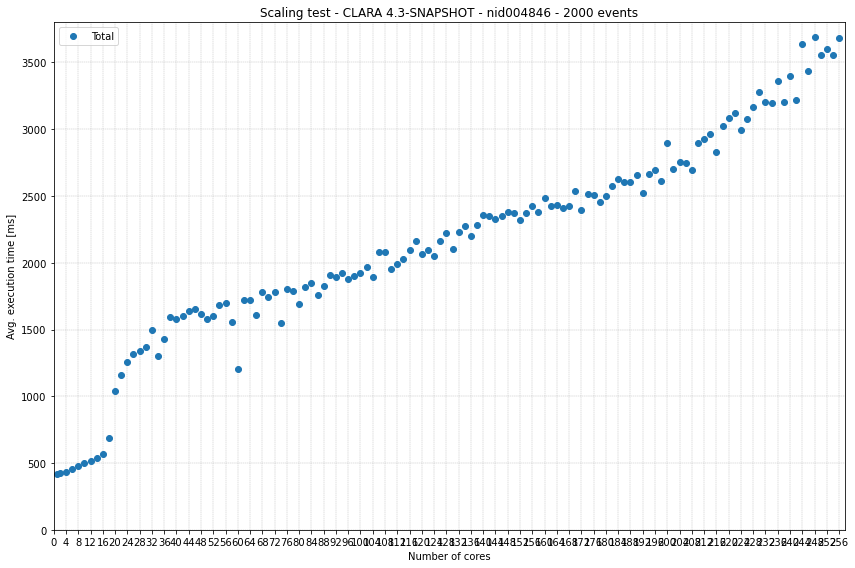

In [7]:
_, ax = plt.subplots()

df.plot(x='Cores', y='TOTAL', ax=ax, label='Total', style='o')

ax.set_title(title)
ax.set_xticks(xticks)
ax.set_xlim(xlim)
ax.set_ylim(0, 3800)
ax.set_xlabel('Number of cores')
ax.set_ylabel('Avg. execution time [ms]')
ax.legend();